In [ ]:
!git clone https://github.com/auspicious3000/autovc

fatal: destination path 'autovc' already exists and is not an empty directory.


In [ ]:
!pip install pydub
!pip install glob2

In [ ]:
import soundfile as sf
import torch 
import pydub
from pydub import AudioSegment
import glob
from pathlib import Path
import os
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load speaker embedding model:
sse = torch.hub.load('RF5/simple-speaker-embedding', 'gru_embedder').to(device)
sse.eval()

Using cache found in /root/.cache/torch/hub/RF5_simple-speaker-embedding_master


GRUEmbedder(
  (model): SpeakerEmbedderGRU(
    (rnn_stack): GRU(80, 768, num_layers=3, batch_first=True, dropout=0.3)
    (projection): Linear(in_features=768, out_features=256, bias=True)
  )
)

In [ ]:
def voiceconv(audio_1, audio_2):
  # Get embedding for source speaker
  sse_src_mel = sse.melspec_from_file(audio_1)
  with torch.no_grad(): 
    src_embedding = torch.flatten(sse(sse_src_mel[None].to(device)))
    # print(src_embedding.size())
  # Get embedding for target speaker
  sse_trg_mel = sse.melspec_from_file(audio_2)
  with torch.no_grad(): 
    trg_embedding = torch.flatten(sse(sse_trg_mel[None].to(device)))

  # Calculate Dot Product between embeddings
  with torch.no_grad():
    s_src = src_embedding.to(device)
    s_trg = trg_embedding.to(device)
    dot_prod = torch.dot(s_src, s_trg)
  return dot_prod.cpu().numpy()

In [ ]:
!mkdir wavs

In [ ]:
!cp /content/autovc/wavs/**/*.wav /content/wavs

In [ ]:
## Example 1
voiceconv('wavs/p225_008.wav', 'wavs/p226_008.wav')

array(0.29208148, dtype=float32)

In [ ]:
files_p225 = list(Path('wavs').glob('p225_*.wav'))
files_p226 = list(Path('wavs').glob('p226_*.wav'))[1:]                          # wavs/p226_003.wav is corrupt
files_p227 = list(Path('wavs').glob('p227_*.wav'))
files_p228 = list(Path('wavs').glob('p228_*.wav'))

In [ ]:
def data_gen(files_1, files_2):
  mat = []
  for file_1 in files_1:
    lst = []
    for file_2 in files_2:
      print(file_1, file_2)
      lst.append(voiceconv(file_1, file_2))
    mat.append(lst)
  
  lst_1 = []
  for file_1 in files_1:
    lst_1.append(file_1)

  lst_2 = []
  for file_1 in files_2:
    lst_2.append(file_1)

  return np.array(mat), lst_1, lst_2

In [ ]:
min_arr = np.zeros([4, 4])
max_arr = np.zeros([4, 4])
for i, files_1 in enumerate([files_p225, files_p226, files_p227, files_p228]):
  for j, files_2 in enumerate([files_p225, files_p226, files_p227, files_p228]):
    print()
    print(i, j)
    print()
    min_arr[i, j] = np.min(data_gen(files_1, files_2)[0])
    max_arr[i, j] = np.unique(data_gen(files_1, files_2)[0])[-2]                # Choose 2nd largest value as dot with itself is 1


0 0

wavs/p225_023.wav wavs/p225_023.wav
wavs/p225_023.wav wavs/p225_019.wav
wavs/p225_023.wav wavs/p225_008.wav
wavs/p225_023.wav wavs/p225_024.wav
wavs/p225_023.wav wavs/p225_020.wav
wavs/p225_023.wav wavs/p225_003.wav
wavs/p225_023.wav wavs/p225_011.wav
wavs/p225_023.wav wavs/p225_022.wav
wavs/p225_023.wav wavs/p225_016.wav
wavs/p225_023.wav wavs/p225_021.wav
wavs/p225_019.wav wavs/p225_023.wav
wavs/p225_019.wav wavs/p225_019.wav
wavs/p225_019.wav wavs/p225_008.wav
wavs/p225_019.wav wavs/p225_024.wav
wavs/p225_019.wav wavs/p225_020.wav
wavs/p225_019.wav wavs/p225_003.wav
wavs/p225_019.wav wavs/p225_011.wav
wavs/p225_019.wav wavs/p225_022.wav
wavs/p225_019.wav wavs/p225_016.wav
wavs/p225_019.wav wavs/p225_021.wav
wavs/p225_008.wav wavs/p225_023.wav
wavs/p225_008.wav wavs/p225_019.wav
wavs/p225_008.wav wavs/p225_008.wav
wavs/p225_008.wav wavs/p225_024.wav
wavs/p225_008.wav wavs/p225_020.wav
wavs/p225_008.wav wavs/p225_003.wav
wavs/p225_008.wav wavs/p225_011.wav
wavs/p225_008.wav wavs

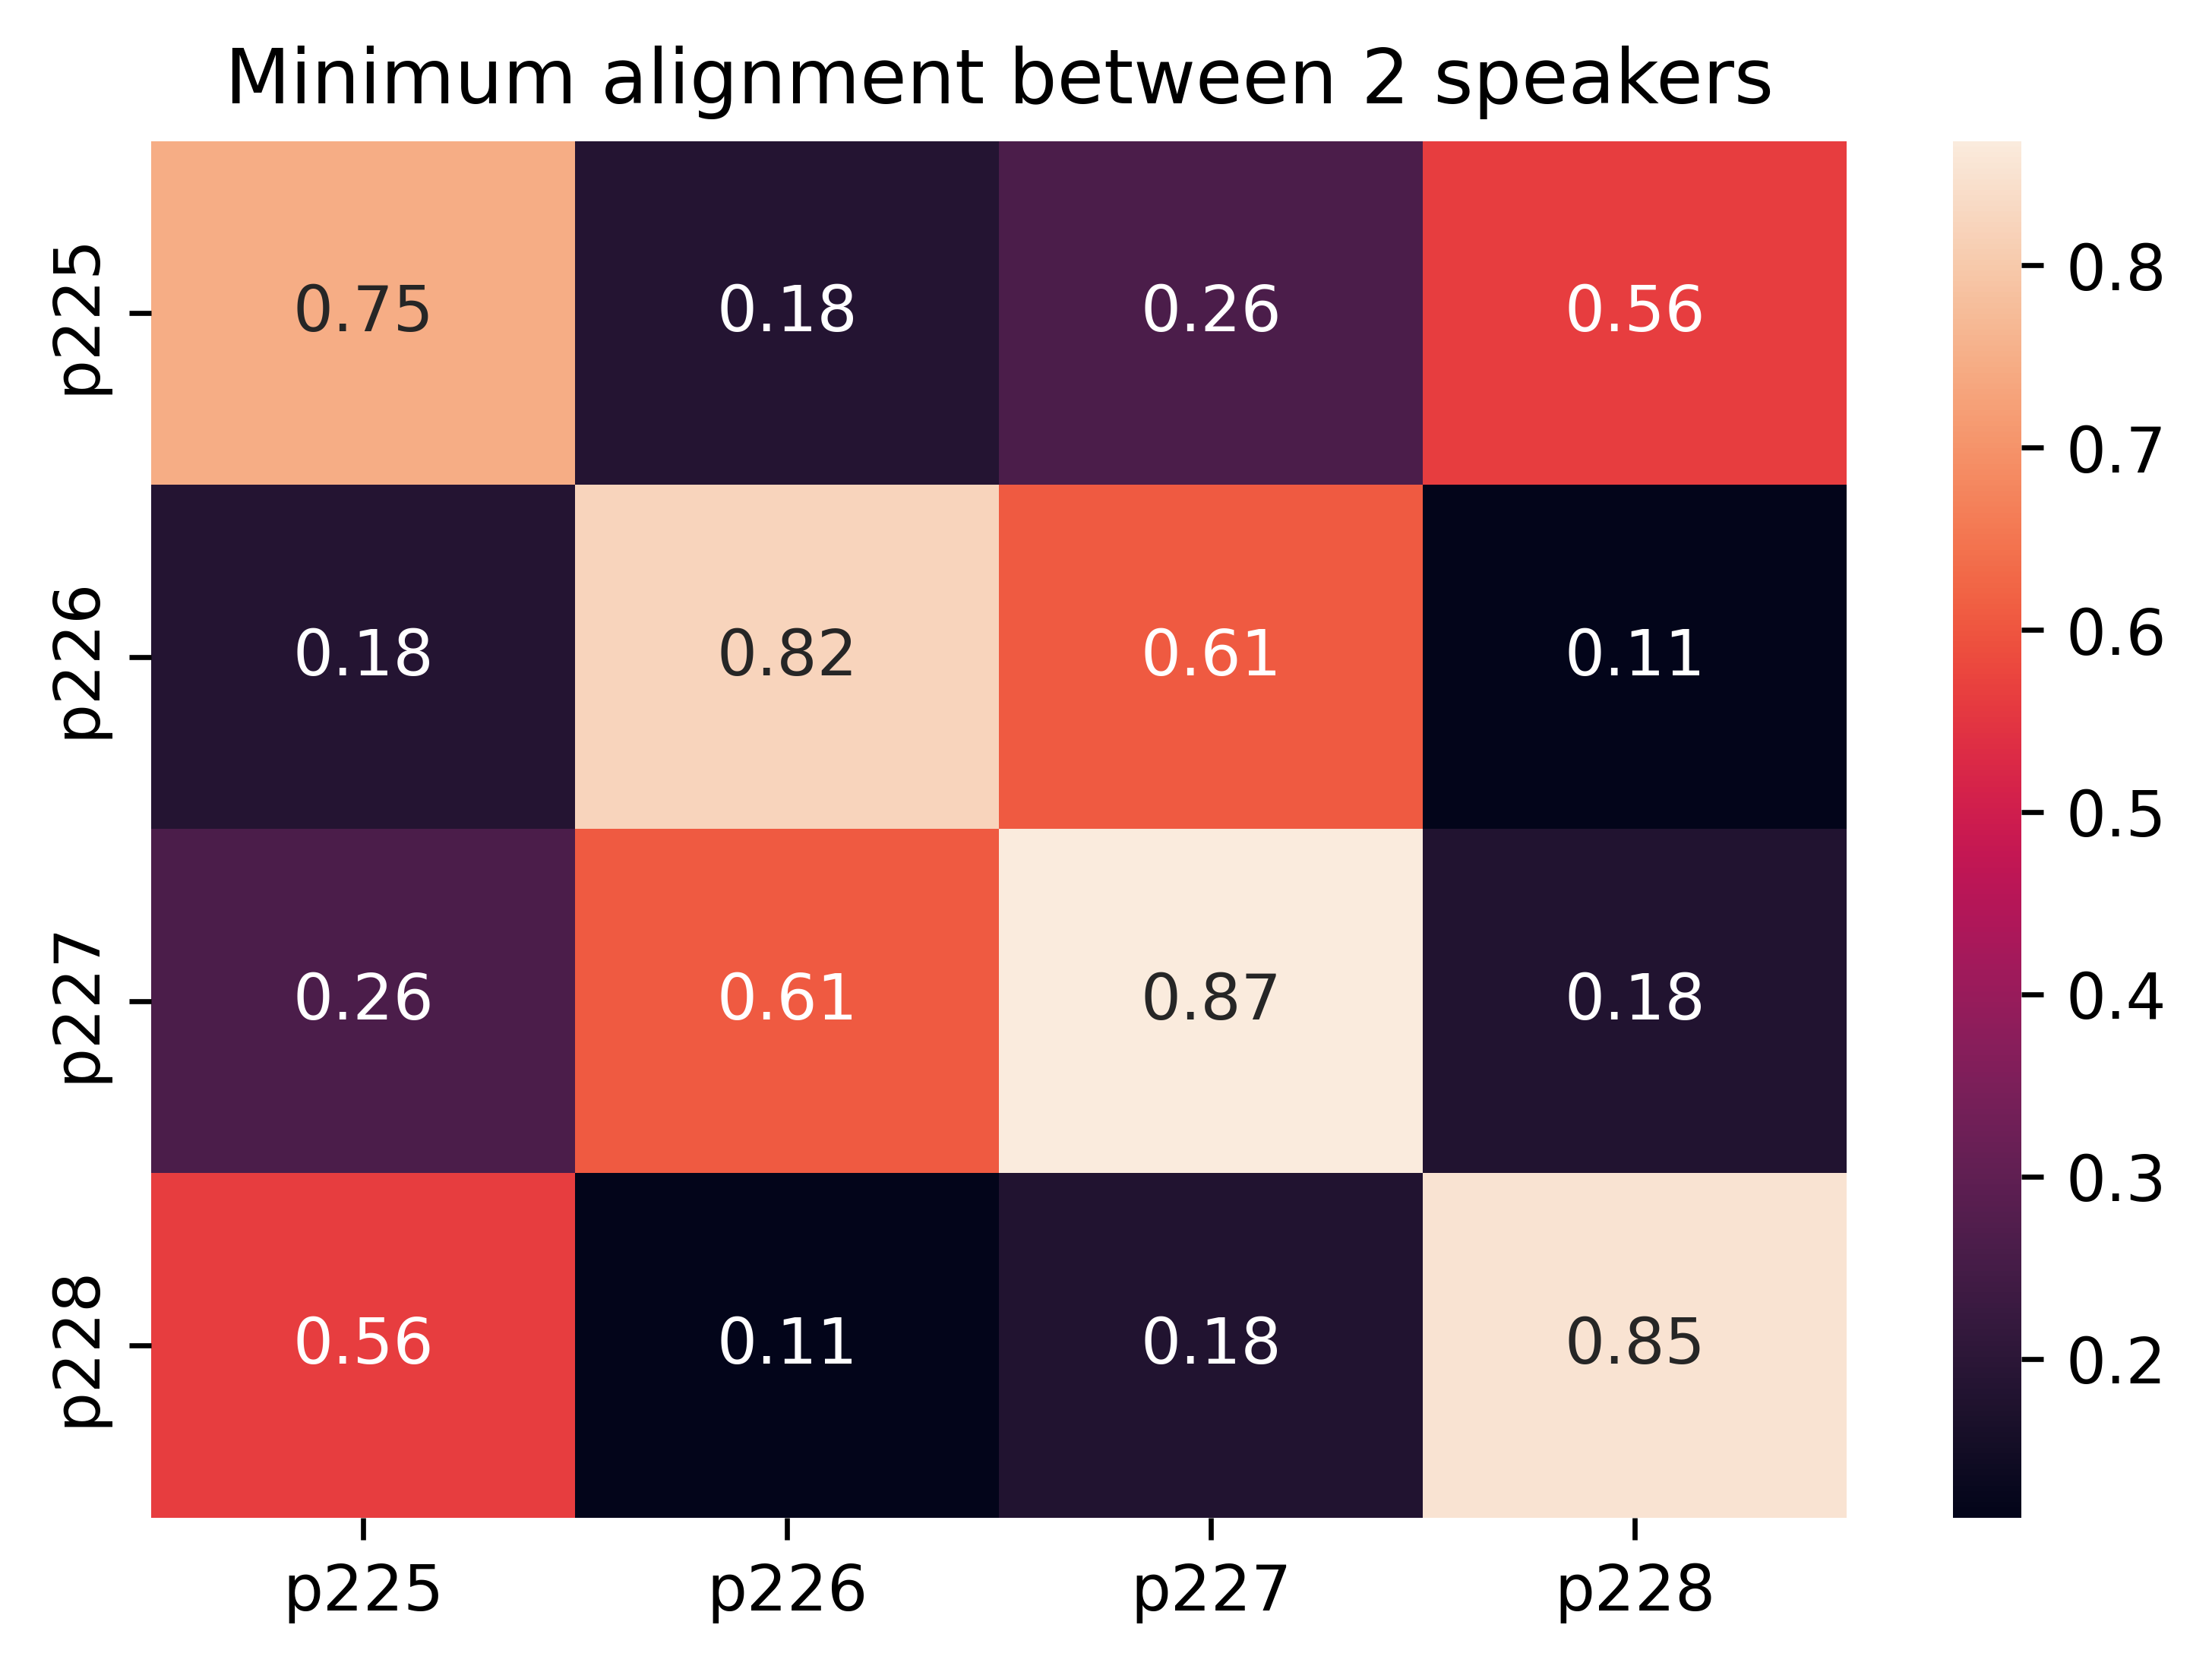

In [ ]:
plt.title('Minimum alignment between 2 speakers')
sb.heatmap(min_arr, annot = True, xticklabels = ['p225', 'p226', 'p227', 'p228'], yticklabels = ['p225', 'p226', 'p227', 'p228']);

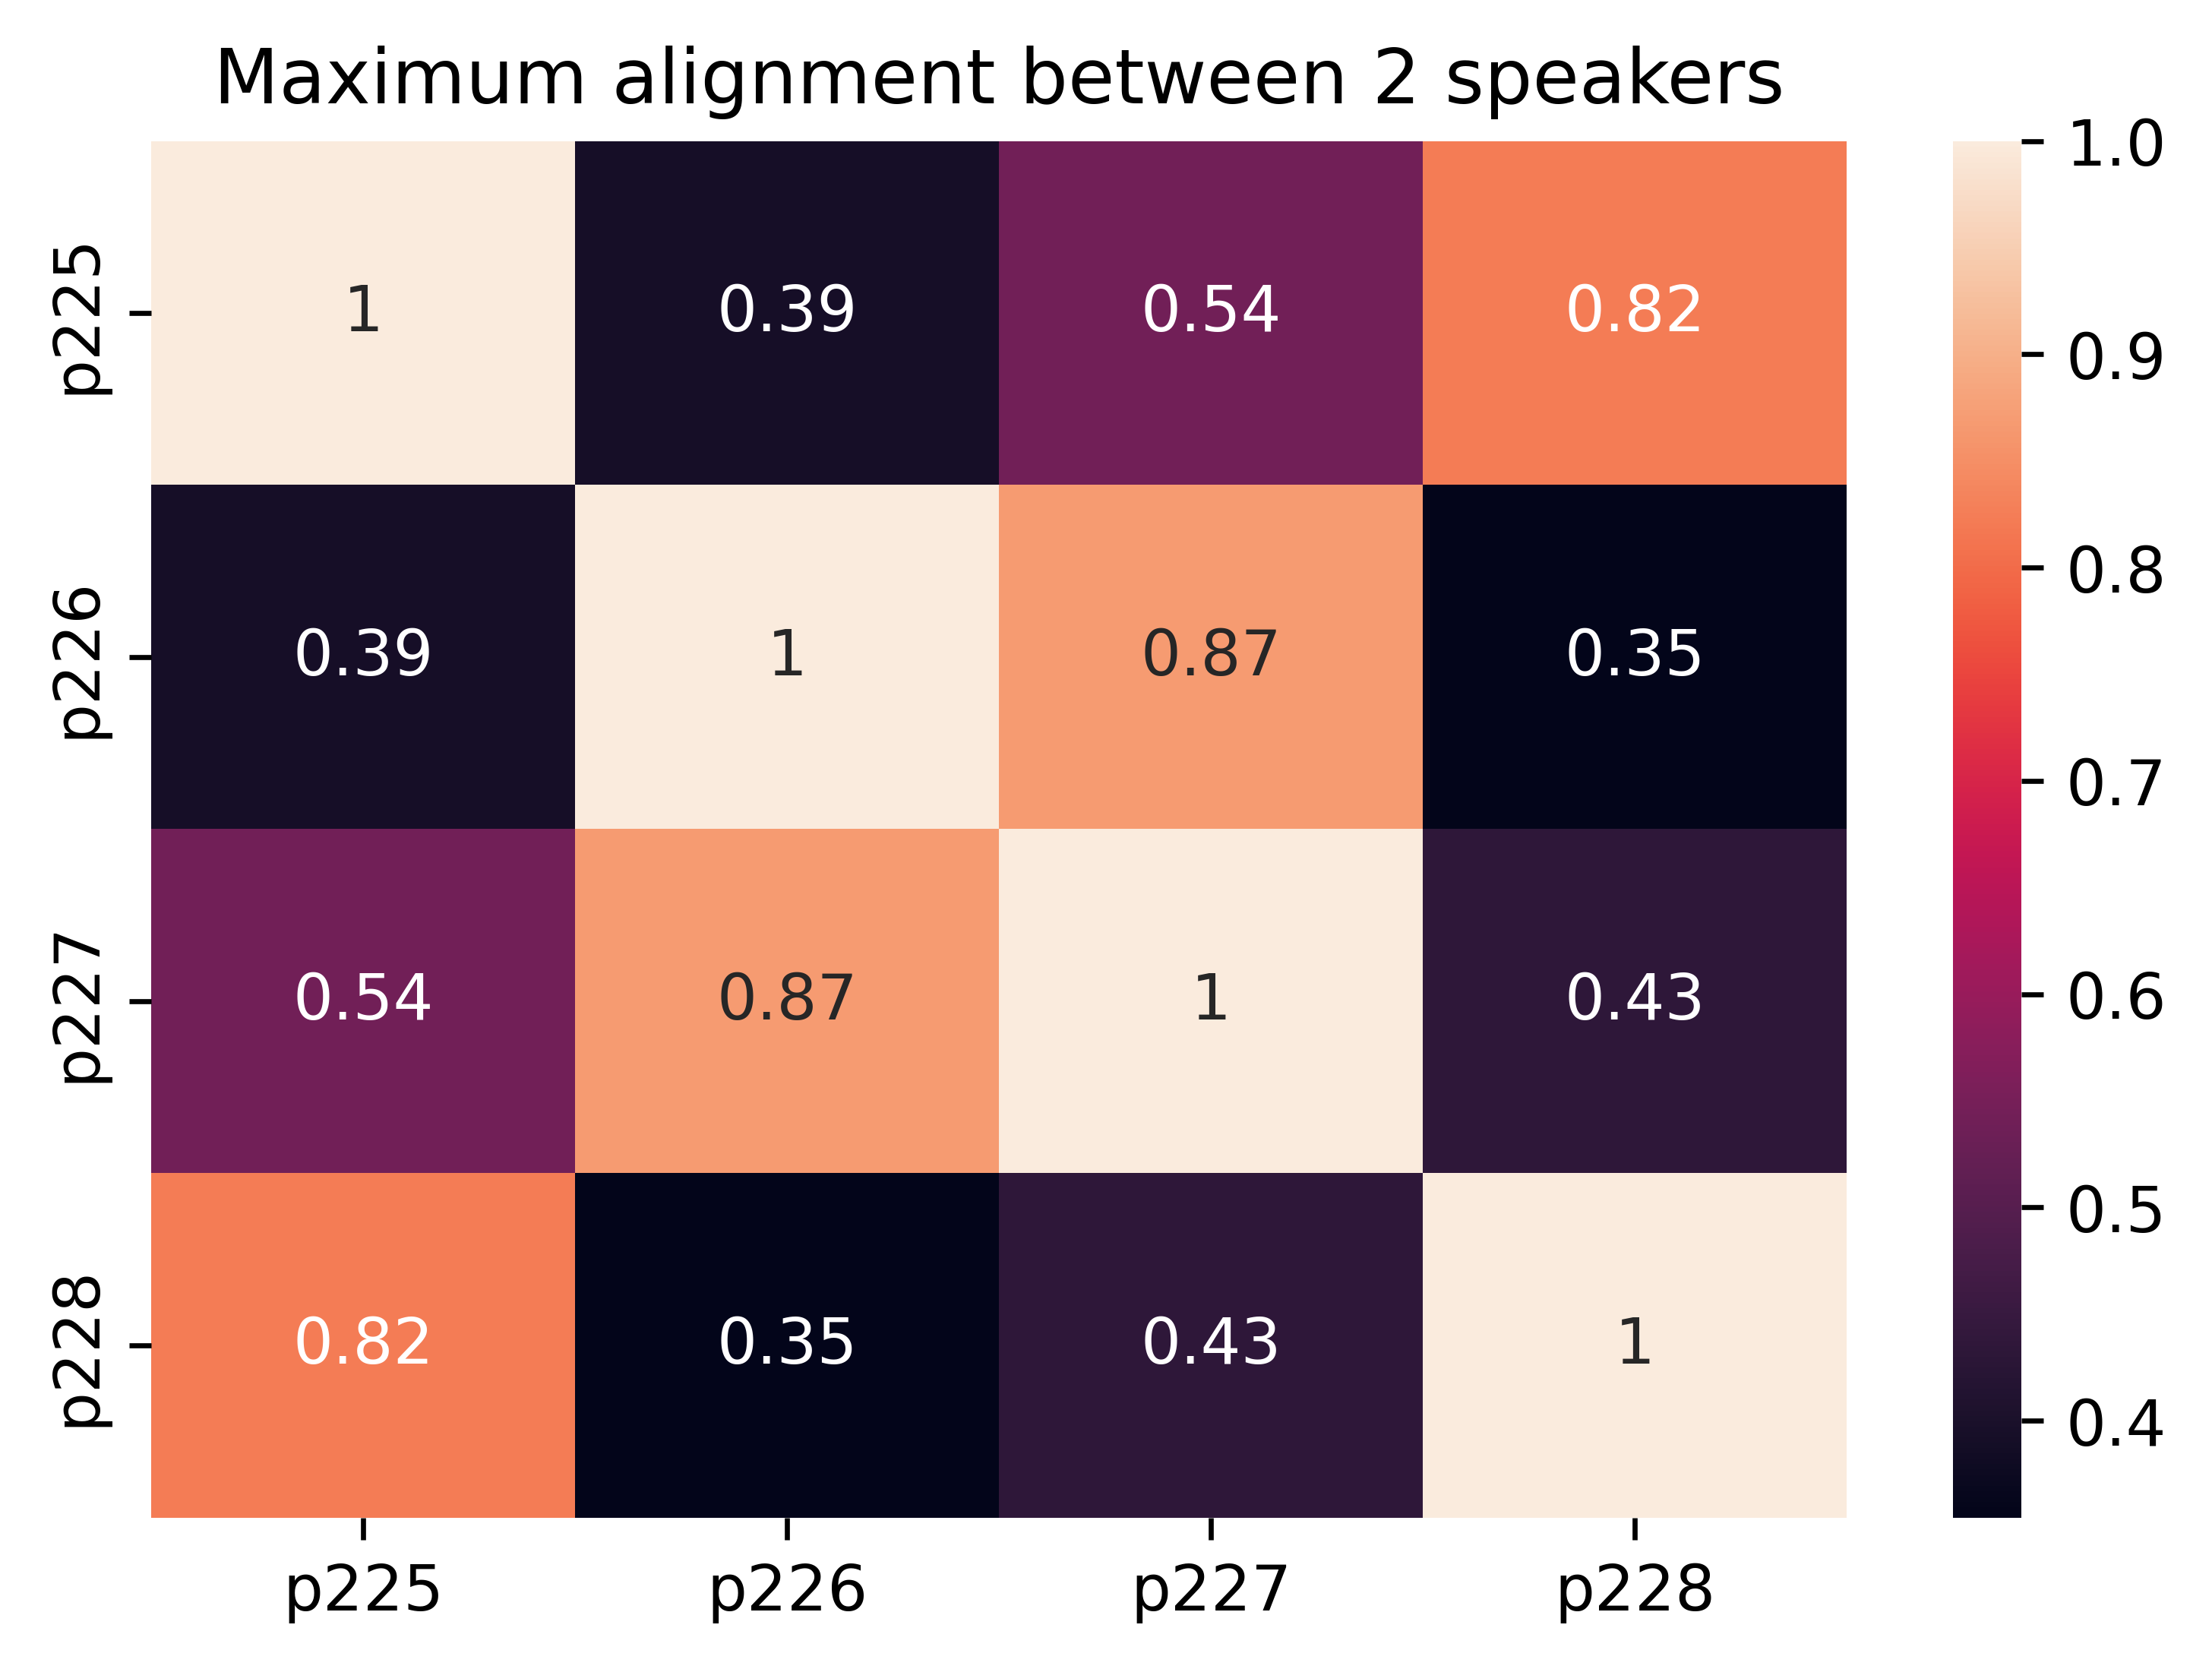

In [ ]:
plt.title('Maximum alignment between 2 speakers')
sb.heatmap(max_arr, annot = True, xticklabels = ['p225', 'p226', 'p227', 'p228'], yticklabels = ['p225', 'p226', 'p227', 'p228']);

In [ ]:
def speaker_identification(file_1, file_2):
  if voiceconv(file_1, file_2) > 0.8:
    print('It is the same speaker.')
    return 1
  else:
    print('The 2 speakers are different.')
    return 0

# Live Test


In [ ]:
!mkdir test

In [ ]:
%cd test/
!gdown 18cnjoqatf0Xgi7SEYUMpsBijr5uE92Rp
!gdown 1mXQJIysckA-YBl3F0MG3TCy2RmhfVEcm
!gdown 1eN-3Xn0QwHLfb5Fs_U_m7hqn8y8VUz-B
!gdown 1JnpqGFR-PEjcrK9xEpbkgK0y88SByjxz
%cd ..

/content/test
Downloading...
From: https://drive.google.com/uc?id=18cnjoqatf0Xgi7SEYUMpsBijr5uE92Rp
To: /content/test/Deep_1.wav
100% 576k/576k [00:00<00:00, 126MB/s]


In [ ]:
speaker_identification('test/Deep_1.wav', 'test/Deep_2.wav');

It is the same speaker.


In [ ]:
speaker_identification('test/Shreya_1.wav', 'test/Shreya_2.wav');

It is the same speaker.


In [ ]:
speaker_identification('test/Deep_1.wav', 'test/Shreya_1.wav');

The 2 speakers are different.


In [ ]:
speaker_identification('test/Deep_1.wav', 'test/Shreya_2.wav');

The 2 speakers are different.


In [ ]:
speaker_identification('test/Deep_2.wav', 'test/Shreya_1.wav');

The 2 speakers are different.


In [ ]:
speaker_identification('test/Deep_2.wav', 'test/Shreya_2.wav');

The 2 speakers are different.
